# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reading data and pre-processing

In [3]:
def read_data(file_name):
    # loading csv
    df = pd.read_csv(file_name)
    
    # removing unnamed columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    return df

In [4]:
# loading csv
df_general = read_data('predictions/train_predictions_general.csv')

df_gk = read_data('predictions/train_predictions_gk.csv')
df_def = read_data('predictions/train_predictions_def.csv')
df_mid = read_data('predictions/train_predictions_mid.csv')
df_fwd = read_data('predictions/train_predictions_fwd.csv')

In [5]:
df_fwd["Name"].unique()

array(['Che-Adams', 'Julian-Alvarez', 'Michail-Antonio', 'Adam-Armstrong',
       'Taiwo-Awoniyi', 'Patson-Daka', 'Emmanuel-Dennis',
       'Odsonne-Edouard', 'Joe-Gelhardt', 'Sam-Greenwood',
       'Erling-Haaland', 'Kai-Havertz', 'Kelechi-Iheanacho', 'Danny-Ings',
       'Brennan-Johnson', 'Harry-Kane', 'Sekou-Mara',
       'Jean-Philippe-Mateta', 'Neal-Maupay', 'Bryan-Mbeumo',
       'Aleksandar-Mitrovic', 'Kieffer-Moore', 'Eddie-Nketiah',
       'Gianluca-Scamacca', 'Dominic-Solanke', 'Sam-Surridge',
       'Ivan-Toney', 'Deniz-Undav', 'Jamie-Vardy', 'Carlos-Vinicius',
       'Ollie-Watkins', 'Danny-Welbeck', 'Callum-Wilson', 'Chris-Wood'],
      dtype=object)

In [6]:
# df.columns

In [7]:
# df["Name"].unique()

In [8]:
# dropping NaNs
# df = df.dropna(axis=0)

In [9]:
# df.shape

In [10]:
# df[df["Name"] == "Erling-Haaland"]

In [11]:
# df["GW"].hist()

In [52]:
df_general.iloc[0]

Date                       2022-10-02
Day                               Sun
Comp                   Premier League
Round                     Matchweek 9
Venue                            Home
Squad                    Leeds United
Opponent                  Aston Villa
Start                               Y
Pos                             AM,CM
Min                              78.0
Gls                               0.0
Ast                               0.0
PK                                0.0
PKatt                             0.0
Sh                                0.0
SoT                               0.0
CrdY                              0.0
CrdR                              0.0
Touches                          25.0
Tkl                               0.0
Int                               0.0
Blocks                            0.0
xG                                0.0
npxG                              0.0
xAG                               0.1
SCA                               2.0
GCA         

# Choosing features and splitting data

In [12]:
features = ["Points", "Was Home", "Opp rating", 'ScoreForLast5', 'ScoreAgainstLast5']
info = ["Name", "GW", "Squad", "Opponent", "Was Home", "Opp rating"]
to_predict = ["Total Points"]

In [13]:
START_GAMEWEEK = 8
GAMEWEEK_TO_PREDICT = 19

In [14]:
def split_data(df, start_gw, gw_to_predict, features, to_predict):
    X_train = df[(df["GW"] >= start_gw) & (df["GW"] <= gw_to_predict - 1)][features]
    y_train = df[(df["GW"] >= start_gw) & (df["GW"] <= gw_to_predict - 1)][to_predict]
    
    X_test = df[df["GW"] == gw_to_predict][features]
    y_test = df[df["GW"] == gw_to_predict][to_predict]

    return X_train, y_train, X_test, y_test

In [15]:
X_train_general, y_train_general, X_test_general, y_test_general = split_data(df_general, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)

X_train_gk, y_train_gk, X_test_gk, y_test_gk = split_data(df_gk, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)
X_train_def, y_train_def, X_test_def, y_test_def = split_data(df_def, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)
X_train_mid, y_train_mid, X_test_mid, y_test_mid = split_data(df_mid, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)
X_train_fwd, y_train_fwd, X_test_fwd, y_test_fwd = split_data(df_fwd, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)

In [16]:
X_train_general.size, y_train_general.size, X_test_general.size, y_test_general.size

(13590, 2718, 795, 159)

In [17]:
X_train_gk.size, y_train_gk.size, X_test_gk.size, y_test_gk.size

(1270, 254, 105, 21)

In [18]:
X_train_def.size, y_train_def.size, X_test_def.size, y_test_def.size

(4610, 922, 255, 51)

In [19]:
X_train_mid.size, y_train_mid.size, X_test_mid.size, y_test_mid.size

(6190, 1238, 340, 68)

In [20]:
X_train_fwd.size, y_train_fwd.size, X_test_fwd.size, y_test_fwd.size

(1520, 304, 95, 19)

# Model and training

In [21]:
model_general = xgb.XGBRegressor(random_state=42)

model_gk = xgb.XGBRegressor(random_state=42)
model_def = xgb.XGBRegressor(random_state=42)
model_mid = xgb.XGBRegressor(random_state=42)
model_fwd = xgb.XGBRegressor(random_state=42)

In [22]:
%%time
model_general.fit(X_train_general, y_train_general)

CPU times: total: 672 ms
Wall time: 332 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [23]:
%%time
model_gk.fit(X_train_gk, y_train_gk)

CPU times: total: 438 ms
Wall time: 80.7 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [24]:
%%time
model_def.fit(X_train_def, y_train_def)

CPU times: total: 562 ms
Wall time: 103 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [25]:
%%time
model_mid.fit(X_train_mid, y_train_mid)

CPU times: total: 531 ms
Wall time: 105 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [26]:
%%time
model_fwd.fit(X_train_fwd, y_train_fwd)

CPU times: total: 312 ms
Wall time: 80.7 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

# Predicting and calculating metrics

In [27]:
# make predictions on the test data
predictions_general = model_general.predict(X_test_general)

predictions_gk = model_gk.predict(X_test_gk)
predictions_def = model_def.predict(X_test_def)
predictions_mid = model_mid.predict(X_test_mid)
predictions_fwd = model_fwd.predict(X_test_fwd)

In [28]:
def calculate_mae_mse(y_test, predictions, title):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    
    print("MAE: ", title, ":", mae)
    print("MSE: ", title, ":", mse)

In [29]:
calculate_mae_mse(y_test_general, predictions_general, "General")

MAE:  General : 2.363066185195491
MSE:  General : 11.378015323305698


In [30]:
calculate_mae_mse(y_test_gk, predictions_gk, "GK")

MAE:  GK : 2.813130159817991
MSE:  GK : 13.410052449607603


In [31]:
calculate_mae_mse(y_test_def, predictions_def, "DEF")

MAE:  DEF : 2.793006492449957
MSE:  DEF : 15.447153553505181


In [32]:
calculate_mae_mse(y_test_mid, predictions_mid, "MID")

MAE:  MID : 2.4418417907813015
MSE:  MID : 11.40314545085926


In [33]:
calculate_mae_mse(y_test_fwd, predictions_fwd, "FWD")

MAE:  FWD : 2.621957085634533
MSE:  FWD : 14.296510362922998


# Predictions - general

In [34]:
# X_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][features]
# y_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][to_predict]

In [35]:
predictions_gk

array([0.0861556 , 2.314792  , 1.8663062 , 3.6810925 , 4.6452885 ,
       4.0472813 , 4.8543034 , 0.9587599 , 4.4624333 , 4.7712092 ,
       0.8673814 , 1.406206  , 2.6570861 , 6.250824  , 4.014363  ,
       4.1574287 , 1.7260846 , 0.35101813, 0.9660232 , 2.304296  ,
       3.1303437 ], dtype=float32)

In [36]:
df_predictions_general = df_general[df_general["GW"] == GAMEWEEK_TO_PREDICT]

df_predictions_gk = df_gk[df_gk["GW"] == GAMEWEEK_TO_PREDICT]
df_predictions_def = df_def[df_def["GW"] == GAMEWEEK_TO_PREDICT]
df_predictions_mid = df_mid[df_mid["GW"] == GAMEWEEK_TO_PREDICT]
df_predictions_fwd = df_fwd[df_fwd["GW"] == GAMEWEEK_TO_PREDICT]

In [37]:
df_predictions_general.shape, df_predictions_gk.shape, df_predictions_def.shape, df_predictions_mid.shape, df_predictions_fwd.shape

((159, 53), (21, 53), (51, 53), (68, 53), (19, 53))

In [38]:
len(predictions_general), len(predictions_gk), len(predictions_def), len(predictions_mid), len(predictions_fwd)

(159, 21, 51, 68, 19)

In [39]:
df_predictions_general["pred"] = predictions_general

df_predictions_gk["pred"] = predictions_gk
df_predictions_def["pred"] = predictions_def
df_predictions_mid["pred"] = predictions_mid
df_predictions_fwd["pred"] = predictions_fwd


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [40]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

In [41]:
df_predictions_general[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
512,Ryan-Christie,19,Bournemouth,Manchester Utd,0.0,1859.299194,2.0,9.620129
2829,Joe-Worrall,19,Nott'ham Forest,Southampton,0.0,1658.088989,6.0,7.969068
1787,Scott-McTominay,19,Manchester Utd,Bournemouth,1.0,1647.227417,0.0,7.776710
1719,Lisandro-Martinez,19,Manchester Utd,Bournemouth,1.0,1647.227417,1.0,7.776710
1768,Scott-McKenna,19,Nott'ham Forest,Southampton,0.0,1658.088989,0.0,6.455028
2655,Raphael-Varane,19,Manchester Utd,Bournemouth,1.0,1647.227417,0.0,6.221357
698,Ibrahima-Diallo,19,Southampton,Nott'ham Forest,1.0,1630.994873,0.0,5.900995
748,Matt-Doherty,19,Tottenham,Crystal Palace,0.0,1753.953369,14.0,5.830732
1036,Morgan-Gibbs-White,19,Nott'ham Forest,Southampton,0.0,1658.088989,3.0,5.709574
1229,Wayne-Hennessey,19,Nott'ham Forest,Southampton,0.0,1658.088989,0.0,5.416448


In [42]:
df_predictions_gk[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
182,Robin-Olsen,19,Aston Villa,Wolves,1.0,1686.353516,0.0,6.250824
95,David-de-Gea,19,Manchester Utd,Bournemouth,1.0,1647.227417,7.0,4.854303
127,Wayne-Hennessey,19,Nott'ham Forest,Southampton,0.0,1658.088989,0.0,4.771209
72,Lukasz-Fabianski,19,West Ham,Leeds United,0.0,1712.961670,2.0,4.645288
116,Dean-Henderson,19,Nott'ham Forest,Southampton,0.0,1658.088989,7.0,4.462433
213,Aaron-Ramsdale,19,Arsenal,Newcastle Utd,1.0,1850.296631,6.0,4.157429
83,Fraser-Forster,19,Tottenham,Crystal Palace,0.0,1753.953369,0.0,4.047281
203,Nick-Pope,19,Newcastle Utd,Arsenal,0.0,1934.447754,10.0,4.014363
60,Ederson,19,Manchester City,Chelsea,0.0,1879.017578,8.0,3.681093
279,Danny-Ward,19,Leicester City,Fulham,1.0,1705.027588,2.0,3.130344


In [43]:
df_predictions_def[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
153,Timothy-Castagne,19,Leicester City,Fulham,1.0,1705.027588,1.0,6.146900
882,Raphael-Varane,19,Manchester Utd,Bournemouth,1.0,1647.227417,0.0,5.182381
904,Kyle-Walker-Peters,19,Southampton,Nott'ham Forest,1.0,1630.994873,2.0,5.157621
953,Joe-Worrall,19,Nott'ham Forest,Southampton,0.0,1658.088989,6.0,4.513363
556,Scott-McKenna,19,Nott'ham Forest,Southampton,0.0,1658.088989,0.0,4.426669
942,Neco-Williams,19,Nott'ham Forest,Southampton,0.0,1658.088989,1.0,4.389479
696,Mohammed-Salisu,19,Southampton,Nott'ham Forest,1.0,1630.994873,2.0,3.748192
536,Tyrell-Malacia,19,Manchester Utd,Bournemouth,1.0,1647.227417,0.0,3.620389
545,Lisandro-Martinez,19,Manchester Utd,Bournemouth,1.0,1647.227417,1.0,3.592389
123,Dan-Burn,19,Newcastle Utd,Arsenal,0.0,1934.447754,6.0,3.510010


In [44]:
df_predictions_mid[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
686,Joelinton,19,Newcastle Utd,Arsenal,0.0,1934.447754,2.0,13.956745
925,Jacob-Murphy,19,Newcastle Utd,Arsenal,0.0,1934.447754,1.0,8.133444
865,Scott-McTominay,19,Manchester Utd,Bournemouth,1.0,1647.227417,0.0,7.837557
329,Moussa-Djenepo,19,Southampton,Nott'ham Forest,1.0,1630.994873,0.0,7.232573
508,Morgan-Gibbs-White,19,Nott'ham Forest,Southampton,0.0,1658.088989,3.0,7.144320
1125,Bukayo-Saka,19,Arsenal,Newcastle Utd,1.0,1850.296631,3.0,6.338803
1247,James-Ward-Prowse,19,Southampton,Nott'ham Forest,1.0,1630.994873,2.0,6.271082
400,Christian-Eriksen,19,Manchester Utd,Bournemouth,1.0,1647.227417,6.0,5.989169
369,Anthony-Elanga,19,Manchester Utd,Bournemouth,1.0,1647.227417,1.0,5.989169
390,Mohamed-Elyounoussi,19,Southampton,Nott'ham Forest,1.0,1630.994873,2.0,5.939992


In [45]:
df_predictions_fwd[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
151,Brennan-Johnson,19,Nott'ham Forest,Southampton,0.0,1658.088989,4.0,8.966330
210,Aleksandar-Mitrovic,19,Fulham,Leicester City,0.0,1770.339966,5.0,7.070798
118,Kai-Havertz,19,Chelsea,Manchester City,1.0,2024.996216,2.0,6.847873
162,Harry-Kane,19,Tottenham,Crystal Palace,0.0,1753.953369,16.0,5.572981
10,Che-Adams,19,Southampton,Nott'ham Forest,1.0,1630.994873,2.0,5.254711
106,Erling-Haaland,19,Manchester City,Chelsea,0.0,1879.017578,2.0,4.336959
202,Bryan-Mbeumo,19,Brentford,Liverpool,1.0,2006.804077,12.0,4.093542
302,Ollie-Watkins,19,Aston Villa,Wolves,1.0,1686.353516,2.0,3.613958
140,Danny-Ings,19,Aston Villa,Wolves,1.0,1686.353516,8.0,3.333787
231,Eddie-Nketiah,19,Arsenal,Newcastle Utd,1.0,1850.296631,1.0,2.283978


# Feature importance and influence

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

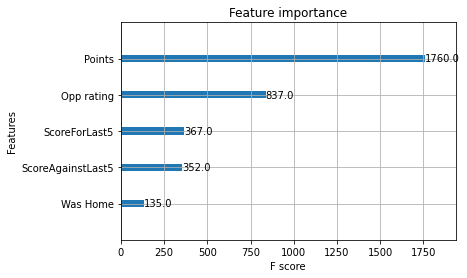

In [46]:
plot_importance(model_fwd)

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


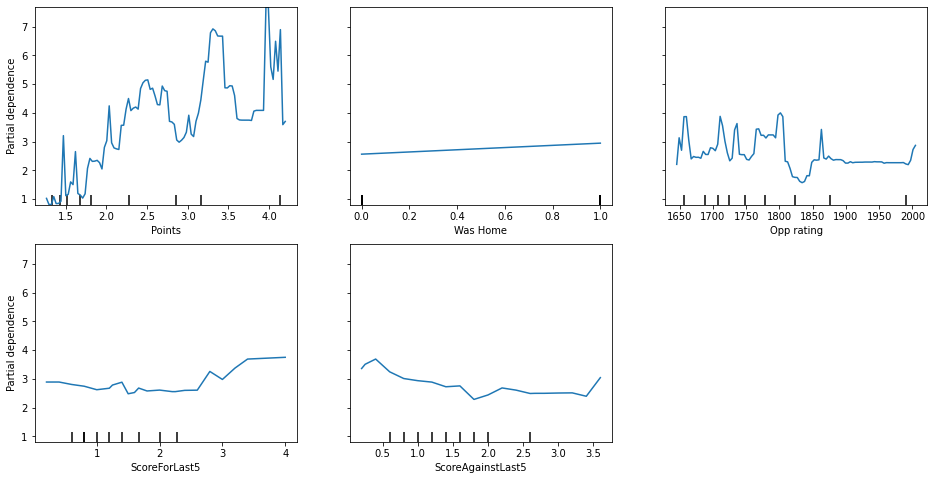

In [47]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_partial_dependence(model_fwd, X_train_fwd, features, ax=ax)

In [48]:
explainer = shap.Explainer(model_fwd, X_train_fwd)
shap_values = explainer(X_train_fwd)

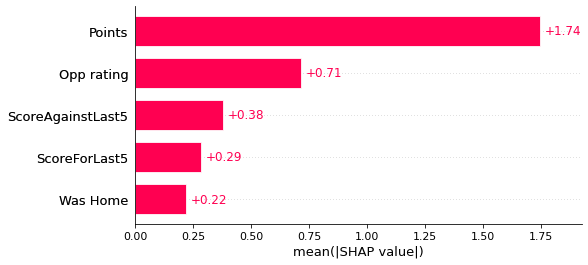

In [49]:
shap.plots.bar(shap_values)

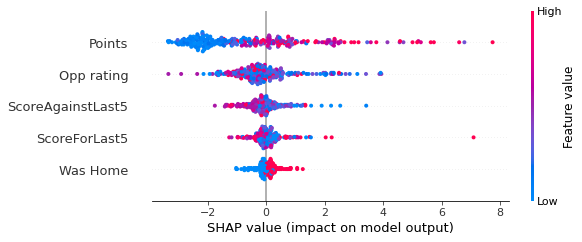

In [50]:
shap.plots.beeswarm(shap_values)

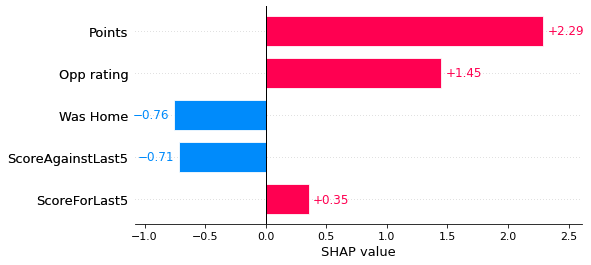

In [51]:
shap.plots.bar(shap_values[3])